# Experiment B: Is it truly isomorphic?

The 1-WL test (color refinement) is a powerful heuristic for graph isomorphism, but it is not perfect. There exist pairs of non-isomorphic graphs that the 1-WL test cannot distinguish. In this section, we:
- Find all groups of graphs that the WL test considers isomorphic.
- For two of the largest isomorphic groups, we go beyond the WL test to prove or disprove true isomorphism.
- We use structural properties (cycle lengths, degree sequences, graphlet counts, clustering, edge centrality) to identify differences.
- If no differences are found, we attempt to construct an explicit node-to-node mapping (isomorphism).
- We report which pairs are truly isomorphic and which are 'WL-fakes', describing the specific graph properties investigated.

In [3]:
import torch
from torch_geometric.datasets import TUDataset
from torch_geometric.utils import to_networkx
import networkx as nx
import collections
import random
import numpy as np
from itertools import combinations
import matplotlib.pyplot as plt

# Helper function from previous notebook
def weisfeiler_lehman_hash(graph):
    colors = {node: data.get('label', 0) for node, data in graph.nodes(data=True)}

    for _ in range(len(graph.nodes())): # Iterate enough times for convergence
        new_colors = {}
        for node in graph.nodes():
            neighbor_colors = sorted([colors[nbr] for nbr in graph.neighbors(node)])
            signature = (colors[node], tuple(neighbor_colors))
            new_colors[node] = hash(signature) # Hash the signature to get a new color

        if new_colors == colors:
            break
        colors = new_colors

    canonical_hash = str(sorted(colors.values()))
    return canonical_hash

def find_isomorphic_groups_from_pyg(dataset):
    hashes = collections.defaultdict(list)

    for i, data in enumerate(dataset):
        g = to_networkx(data, node_attrs=['x'])
        nx.set_node_attributes(g, {j: int(x[0]) for j, x in enumerate(data.x)}, 'label')
        
        if len(g) > 0:
            h = weisfeiler_lehman_hash(g)
            hashes[h].append(i)

    isomorphic_groups = {h: indices for h, indices in hashes.items() if len(indices) > 1}
    return isomorphic_groups

In [4]:
def get_cycle_lengths_with_counts(graph):
    """Returns a dictionary of cycle lengths and their counts in the graph."""
    cycles = {}
    for length in range(3, len(graph.nodes()) + 1):
        try:
            # Find all cycles of given length
            cycle_basis = list(nx.simple_cycles(graph))
            cycles_of_length = [c for c in cycle_basis if len(c) == length]
            if cycles_of_length:
                cycles[length] = len(cycles_of_length)
        except nx.NetworkXNoCycle:
            continue
    return cycles

def get_graphlet_counts(graph):
    """
    Count occurrences of small graphlets (subgraphs of size 3 and 4).
    Returns counts of different patterns.
    """
    patterns = {
        'triangles': 0,  # Complete graph of 3 nodes
        'paths_3': 0,    # Path of length 2 (3 nodes)
        'stars_3': 0,    # Central node with 2 neighbors
        'paths_4': 0,    # Path of length 3 (4 nodes)
        'cycles_4': 0,   # Cycle of length 4
        'claws': 0       # Central node with 3 neighbors
    }
    
    # Count 3-node patterns
    for nodes in combinations(graph.nodes(), 3):
        subg = graph.subgraph(nodes)
        edges = len(subg.edges())
        if edges == 3:
            patterns['triangles'] += 1
        elif edges == 2:
            patterns['paths_3'] += 1
        elif edges == 1:
            patterns['stars_3'] += 1
    
    # Count selected 4-node patterns
    for nodes in combinations(graph.nodes(), 4):
        subg = graph.subgraph(nodes)
        edges = len(subg.edges())
        degrees = [d for _, d in subg.degree()]
        
        if edges == 4 and max(degrees) == 2:  # Cycle
            patterns['cycles_4'] += 1
        elif edges == 3 and max(degrees) == 2:  # Path
            patterns['paths_4'] += 1
        elif edges == 3 and 3 in degrees:  # Claw
            patterns['claws'] += 1
            
    return patterns

def get_local_clustering_distribution(graph):
    """Returns sorted list of local clustering coefficients."""
    clustering = nx.clustering(graph)
    return sorted(clustering.values())

def get_edge_betweenness_distribution(graph):
    """Returns sorted list of edge betweenness centrality values."""
    edge_btw = nx.edge_betweenness_centrality(graph)
    return sorted(edge_btw.values())

def compare_graphs_detailed(g1, g2):
    """
    Performs an extensive comparison of two graphs using multiple invariants.
    Returns a dictionary of results, detailed differences, and overall conclusion.
    """
    results = {}
    differences = {}
    
    # 1. Basic Structure
    results['nodes'] = len(g1.nodes()) == len(g2.nodes())
    results['edges'] = len(g1.edges()) == len(g2.edges())
    
    if not results['nodes'] or not results['edges']:
        differences['basic'] = f"Different number of nodes ({len(g1.nodes())} vs {len(g2.nodes())}) " + \
                             f"or edges ({len(g1.edges())} vs {len(g2.edges())})"
    
    # 2. Degree Sequence
    deg_seq1 = sorted([d for _, d in g1.degree()])
    deg_seq2 = sorted([d for _, d in g2.degree()])
    results['degree_sequences'] = deg_seq1 == deg_seq2
    
    if not results['degree_sequences']:
        differences['degrees'] = f"Different degree sequences: {deg_seq1} vs {deg_seq2}"
    
    # 3. Cycle Structure
    cycles1 = get_cycle_lengths_with_counts(g1)
    cycles2 = get_cycle_lengths_with_counts(g2)
    results['cycle_structure'] = cycles1 == cycles2
    
    if not results['cycle_structure']:
        differences['cycles'] = f"Different cycle structures: {cycles1} vs {cycles2}"
    
    # 4. Local Properties
    graphlets1 = get_graphlet_counts(g1)
    graphlets2 = get_graphlet_counts(g2)
    results['graphlet_counts'] = graphlets1 == graphlets2
    
    if not results['graphlet_counts']:
        diff_patterns = {k: (graphlets1[k], graphlets2[k]) 
                        for k in graphlets1 if graphlets1[k] != graphlets2[k]}
        differences['graphlets'] = f"Different graphlet counts: {diff_patterns}"
    
    # 5. Clustering
    clust1 = get_local_clustering_distribution(g1)
    clust2 = get_local_clustering_distribution(g2)
    results['clustering'] = clust1 == clust2
    
    if not results['clustering']:
        differences['clustering'] = "Different clustering coefficient distributions"
    
    # 6. Edge Centrality
    btw1 = get_edge_betweenness_distribution(g1)
    btw2 = get_edge_betweenness_distribution(g2)
    results['edge_centrality'] = btw1 == btw2
    
    if not results['edge_centrality']:
        differences['centrality'] = "Different edge betweenness centrality distributions"
    
    # Overall assessment
    could_be_isomorphic = all(results.values())
    
    return results, differences, could_be_isomorphic

# Get the two largest isomorphic groups
print("Finding isomorphic groups using WL test...")
dataset = TUDataset(root='T-7/AIDS', name='AIDS', use_node_attr=True)
isomorphic_groups = find_isomorphic_groups_from_pyg(dataset)
groups = sorted(isomorphic_groups.values(), key=len, reverse=True)[:2]
# Print the two largest isomorphic groups being considered
print("\nGroups selected for true isomorphism analysis:")
for i, group in enumerate(groups[:2]):
    print(f"Group {i+1} (size {len(group)}): {group}")

print("\nAnalyzing WL test results:")
print("-" * 50)

for group_idx, group in enumerate(groups):
    print(f"\nGroup {group_idx + 1}:")
    print(f"Size: {len(group)} graphs")
    print(f"Graph indices: {group}")
    
    # Convert the first graph in the group to serve as reference
    ref_data = dataset[group[0]]
    ref_graph = to_networkx(ref_data, node_attrs=['x'])
    nx.set_node_attributes(ref_graph, {j: int(x[0]) for j, x in enumerate(ref_data.x)}, 'label')
    
    # Compare with each other graph in the group
    print(f"\nVerifying isomorphism within Group {group_idx + 1}:")
    print("-" * 30)
    
    for idx in group[1:]:
        data = dataset[idx]
        g = to_networkx(data, node_attrs=['x'])
        nx.set_node_attributes(g, {j: int(x[0]) for j, x in enumerate(data.x)}, 'label')
        
        print(f"\nComparing reference graph {group[0]} with graph {idx}:")
        results, differences, could_be_isomorphic = compare_graphs_detailed(ref_graph, g)
        
        # Print invariant check results only if there are differences
        if not could_be_isomorphic:
            print("\nFound differences in invariants:")
            for k, v in results.items():
                if not v:  # Only print failed checks
                    print(f"- {k}: ✗")
            print("\nDetailed differences:")
            for k, v in differences.items():
                print(f"- {k}: {v}")
        else:
            print("All invariants match ✓")
        
        # Check for true isomorphism
        try:
            iso = nx.is_isomorphic(ref_graph, g, 
                                 node_match=lambda n1, n2: n1.get('label') == n2.get('label'))
            if iso:
                print("→ Confirmed: Graphs are truly isomorphic")
                matcher = nx.isomorphism.GraphMatcher(
                    ref_graph, g, 
                    node_match=lambda n1, n2: n1.get('label') == n2.get('label')
                )
                if matcher.is_isomorphic():
                    mapping = matcher.mapping
                    print("Node mapping:")
                    for n1, n2 in mapping.items():
                        print(f"  {n1} → {n2} (Label: {ref_graph.nodes[n1]['label']})")
            else:
                print("→ WL-fake detected: Graphs match on all invariants but are NOT isomorphic!")
        except Exception as e:
            print(f"Error during isomorphism check: {e}")

print("\nSummary:")
print("-" * 50)
print("WL test effectiveness:")
for group_idx, group in enumerate(groups):
    true_iso_count = 0
    false_positive_count = 0
    
    for idx in group[1:]:
        data = dataset[idx]
        g = to_networkx(data, node_attrs=['x'])
        nx.set_node_attributes(g, {j: int(x[0]) for j, x in enumerate(data.x)}, 'label')
        
        is_true_iso = nx.is_isomorphic(ref_graph, g,
                                      node_match=lambda n1, n2: n1.get('label') == n2.get('label'))
        if is_true_iso:
            true_iso_count += 1
        else:
            false_positive_count += 1
    
    total = len(group) - 1
    print(f"\nGroup {group_idx + 1} results:")
    print(f"- True isomorphisms: {true_iso_count}/{total}")
    print(f"- WL-fake positives: {false_positive_count}/{total}")
    if false_positive_count > 0:
        print("⚠️ WL test failed to distinguish some non-isomorphic graphs in this group")

Finding isomorphic groups using WL test...

Groups selected for true isomorphism analysis:
Group 1 (size 8): [709, 1270, 1454, 1585, 1607, 1809, 1964, 1977]
Group 2 (size 3): [189, 1004, 1711]

Analyzing WL test results:
--------------------------------------------------

Group 1:
Size: 8 graphs
Graph indices: [709, 1270, 1454, 1585, 1607, 1809, 1964, 1977]

Verifying isomorphism within Group 1:
------------------------------

Comparing reference graph 709 with graph 1270:

Groups selected for true isomorphism analysis:
Group 1 (size 8): [709, 1270, 1454, 1585, 1607, 1809, 1964, 1977]
Group 2 (size 3): [189, 1004, 1711]

Analyzing WL test results:
--------------------------------------------------

Group 1:
Size: 8 graphs
Graph indices: [709, 1270, 1454, 1585, 1607, 1809, 1964, 1977]

Verifying isomorphism within Group 1:
------------------------------

Comparing reference graph 709 with graph 1270:

Found differences in invariants:
- edge_centrality: ✗

Detailed differences:
- central

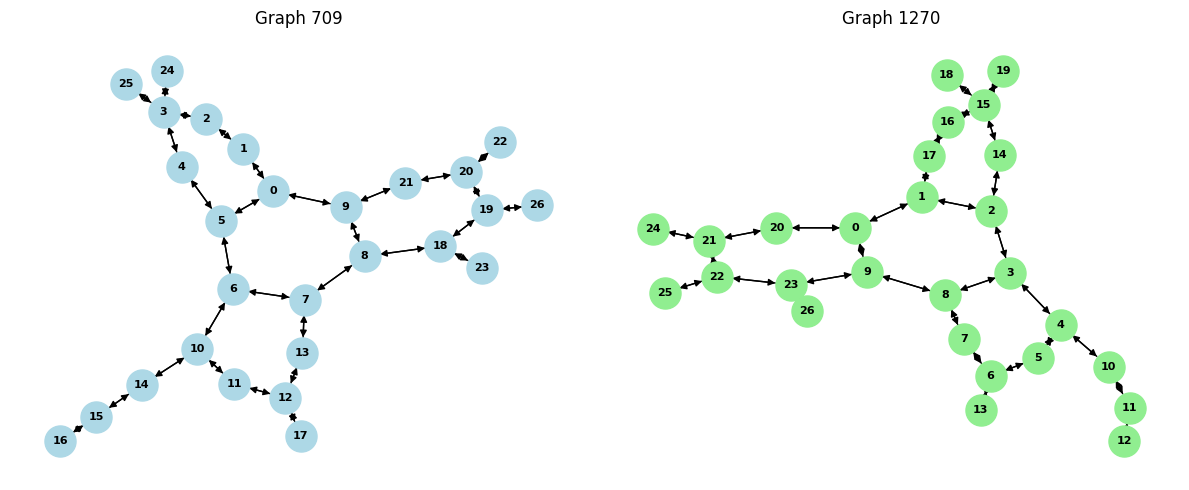

In [5]:
def visualize_graph_pair(g1, g2, title1="Graph 1", title2="Graph 2"):
    """
    Visualizes two graphs side by side for comparison.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Layout for both graphs
    pos1 = nx.spring_layout(g1)
    pos2 = nx.spring_layout(g2)
    
    # Draw first graph
    nx.draw(g1, pos1, ax=ax1, with_labels=True, node_color='lightblue', 
            node_size=500, font_size=8, font_weight='bold')
    ax1.set_title(title1)
    
    # Draw second graph
    nx.draw(g2, pos2, ax=ax2, with_labels=True, node_color='lightgreen', 
            node_size=500, font_size=8, font_weight='bold')
    ax2.set_title(title2)
    
    plt.tight_layout()
    plt.show()

# Example usage: Visualize a pair of graphs from the largest group
if len(groups[0]) >= 2:
    g1_data = dataset[groups[0][0]]
    g2_data = dataset[groups[0][1]]
    
    g1 = to_networkx(g1_data, node_attrs=['x'])
    g2 = to_networkx(g2_data, node_attrs=['x'])
    
    visualize_graph_pair(g1, g2, 
                        f"Graph {groups[0][0]}", 
                        f"Graph {groups[0][1]}")


Detailed Isomorphism Analysis of Largest Groups

Analyzing Group 1:
----------------------------------------
Group Size: 8 graphs
Graph indices in group: [709, 1270, 1454, 1585, 1607, 1809, 1964, 1977]

Comparing graphs 709 and 1270:
Basic Properties:
- Graph 709: 27 nodes, 60 edges
- Graph 1270: 27 nodes, 60 edges

Weisfeiler-Lehman Test:
✓ Graphs are isomorphic according to WL test

Generating visual comparison...


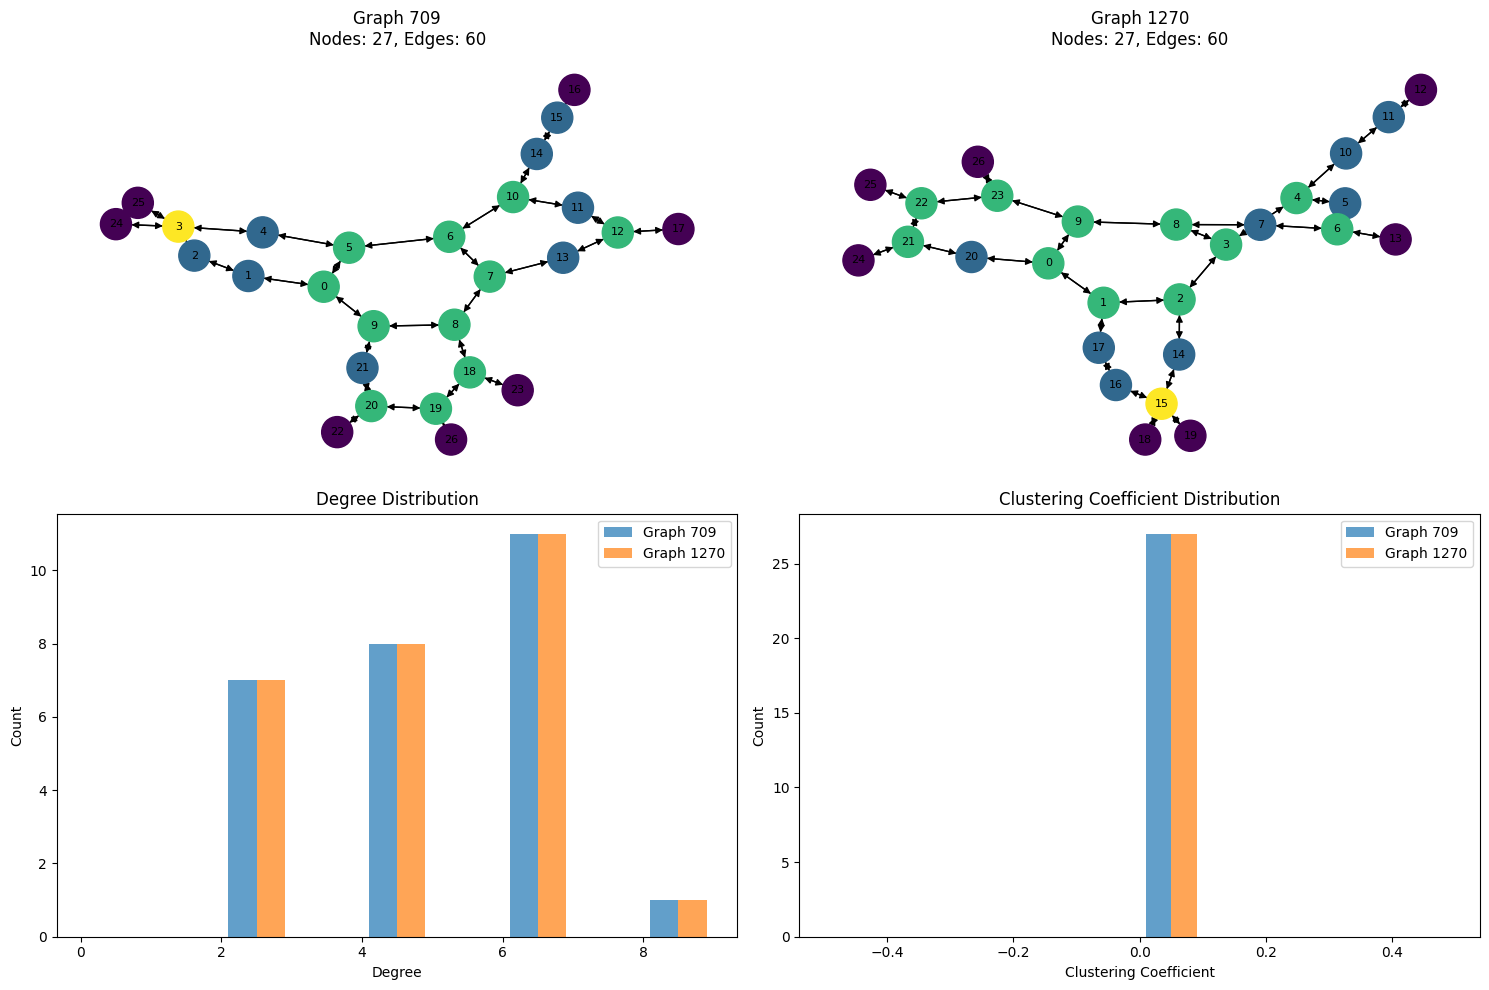


Structural Analysis Results:
----------------------------------------

Invariant Checks:
- nodes: ✓
- edges: ✓
- degree_sequences: ✓
- cycle_structure: ✓
- graphlet_counts: ✓
- clustering: ✓
- edge_centrality: ✗

Detailed Differences Found:
- centrality: Different edge betweenness centrality distributions

Final Verdict:
✓ CONFIRMED: Graphs are truly isomorphic!

Node Mapping:
  Node 9 → Node 0 (Label: 1)
  Node 0 → Node 1 (Label: 1)
  Node 5 → Node 2 (Label: 1)
  Node 6 → Node 3 (Label: 1)
  Node 10 → Node 4 (Label: 1)
  Node 11 → Node 5 (Label: 1)
  Node 12 → Node 6 (Label: 1)
  Node 13 → Node 7 (Label: 2)
  Node 7 → Node 8 (Label: 1)
  Node 8 → Node 9 (Label: 1)
  Node 14 → Node 10 (Label: 1)
  Node 15 → Node 11 (Label: 1)
  Node 16 → Node 12 (Label: 1)
  Node 17 → Node 13 (Label: 2)
  Node 4 → Node 14 (Label: 2)
  Node 3 → Node 15 (Label: 1)
  Node 2 → Node 16 (Label: 1)
  Node 1 → Node 17 (Label: 1)
  Node 24 → Node 18 (Label: 1)
  Node 25 → Node 19 (Label: 1)
  Node 21 → Node 20

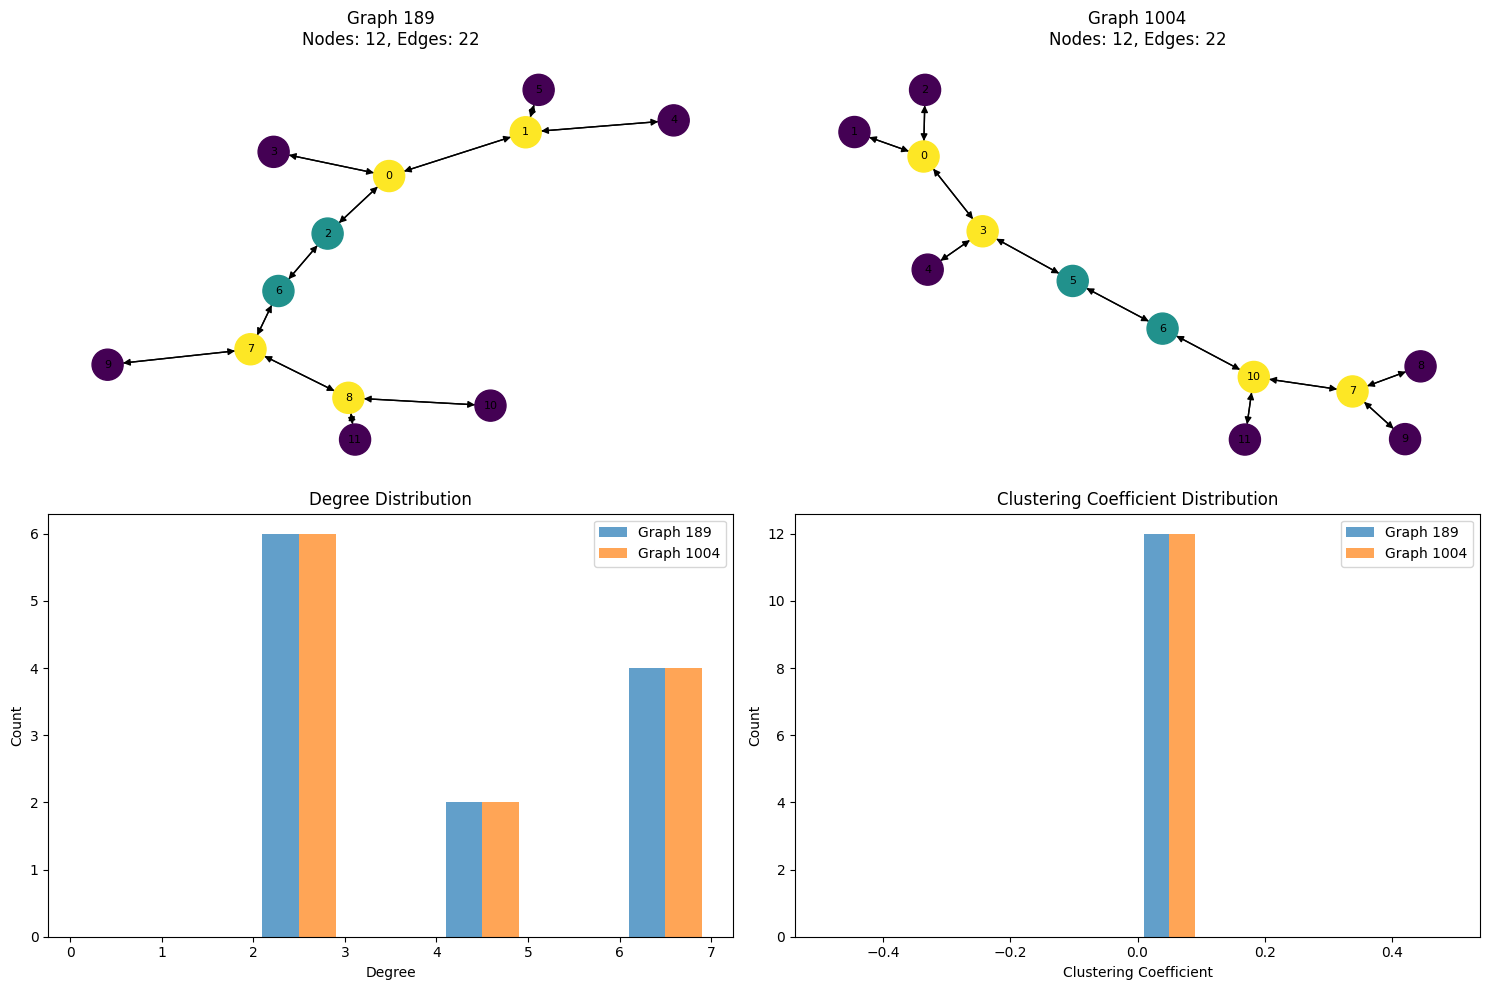


Structural Analysis Results:
----------------------------------------

Invariant Checks:
- nodes: ✓
- edges: ✓
- degree_sequences: ✓
- cycle_structure: ✓
- graphlet_counts: ✓
- clustering: ✓
- edge_centrality: ✓

Final Verdict:
✓ CONFIRMED: Graphs are truly isomorphic!

Node Mapping:
  Node 1 → Node 0 (Label: 4)
  Node 4 → Node 1 (Label: 1)
  Node 5 → Node 2 (Label: 1)
  Node 0 → Node 3 (Label: 1)
  Node 3 → Node 4 (Label: 5)
  Node 2 → Node 5 (Label: 5)
  Node 6 → Node 6 (Label: 5)
  Node 7 → Node 10 (Label: 1)
  Node 8 → Node 7 (Label: 4)
  Node 10 → Node 8 (Label: 1)
  Node 11 → Node 9 (Label: 1)
  Node 9 → Node 11 (Label: 5)

Summary:
- WL Test Result: Passed
- True Isomorphism: Yes
----------------------------------------

FINAL ISOMORPHISM STATUS SUMMARY

Group 1 (Size: 8 graphs):
- WL Test: Passed ✓
- True Isomorphism: Yes ✓

Group 2 (Size: 3 graphs):
- WL Test: Passed ✓
- True Isomorphism: Yes ✓

Overall Conclusion:
✓ All groups contain truly isomorphic graphs


In [ ]:
def visualize_graph_comparison(g1, g2, title1="Graph 1", title2="Graph 2"):
    """
    Creates a detailed visual comparison of two graphs, highlighting structural properties.
    """
    fig = plt.figure(figsize=(15, 10))
    
    # Layout for main graph drawings
    ax1 = plt.subplot2grid((2, 2), (0, 0))
    ax2 = plt.subplot2grid((2, 2), (0, 1))
    ax3 = plt.subplot2grid((2, 2), (1, 0))
    ax4 = plt.subplot2grid((2, 2), (1, 1))
    
    # 1. Draw the graphs
    pos1 = nx.spring_layout(g1)
    pos2 = nx.spring_layout(g2)
    
    # Color nodes by degree
    node_colors1 = [g1.degree(n) for n in g1.nodes()]
    node_colors2 = [g2.degree(n) for n in g2.nodes()]
    
    nx.draw(g1, pos1, ax=ax1, with_labels=True, 
           node_color=node_colors1, cmap=plt.cm.viridis,
           node_size=500, font_size=8)
    ax1.set_title(f"{title1}\nNodes: {len(g1.nodes())}, Edges: {len(g1.edges())}")
    
    nx.draw(g2, pos2, ax=ax2, with_labels=True,
           node_color=node_colors2, cmap=plt.cm.viridis,
           node_size=500, font_size=8)
    ax2.set_title(f"{title2}\nNodes: {len(g2.nodes())}, Edges: {len(g2.edges())}")
    
    # 2. Plot degree distributions
    degrees1 = [d for _, d in g1.degree()]
    degrees2 = [d for _, d in g2.degree()]
    max_degree = max(max(degrees1), max(degrees2))
    bins = range(max_degree + 2)
    
    ax3.hist([degrees1, degrees2], bins=bins, label=[title1, title2], alpha=0.7)
    ax3.set_title("Degree Distribution")
    ax3.set_xlabel("Degree")
    ax3.set_ylabel("Count")
    ax3.legend()
    
    # 3. Plot clustering coefficients
    clustering1 = list(nx.clustering(g1).values())
    clustering2 = list(nx.clustering(g2).values())
    
    ax4.hist([clustering1, clustering2], bins=10, label=[title1, title2], alpha=0.7)
    ax4.set_title("Clustering Coefficient Distribution")
    ax4.set_xlabel("Clustering Coefficient")
    ax4.set_ylabel("Count")
    ax4.legend()
    
    plt.tight_layout()
    plt.show()

# Visualize and compare a pair of graphs from each group
print("\nDetailed Isomorphism Analysis of Largest Groups")
print("=" * 50)

group_results = []  # Store results for final summary

for group_idx, group in enumerate(groups[:2]):  # Look at first two groups
    if len(group) >= 2:  # Need at least 2 graphs to compare
        print(f"\nAnalyzing Group {group_idx + 1}:")
        print("-" * 40)
        print(f"Group Size: {len(group)} graphs")
        print(f"Graph indices in group: {group}")
        
        # Get two graphs from the group
        g1_data = dataset[group[0]]
        g2_data = dataset[group[1]]
        
        g1 = to_networkx(g1_data, node_attrs=['x'])
        g2 = to_networkx(g2_data, node_attrs=['x'])
        
        # Set node labels
        nx.set_node_attributes(g1, {j: int(x[0]) for j, x in enumerate(g1_data.x)}, 'label')
        nx.set_node_attributes(g2, {j: int(x[0]) for j, x in enumerate(g2_data.x)}, 'label')
        
        print(f"\nComparing graphs {group[0]} and {group[1]}:")
        print("Basic Properties:")
        print(f"- Graph {group[0]}: {len(g1.nodes())} nodes, {len(g1.edges())} edges")
        print(f"- Graph {group[1]}: {len(g2.nodes())} nodes, {len(g2.edges())} edges")
        
        # First check WL test result
        wl_result = weisfeiler_lehman_hash(g1) == weisfeiler_lehman_hash(g2)
        print("\nWeisfeiler-Lehman Test:")
        print(f"{'✓' if wl_result else '✗'} Graphs {'are' if wl_result else 'are NOT'} isomorphic according to WL test")
        
        # Show structural comparison visualization
        print("\nGenerating visual comparison...")
        visualize_graph_comparison(g1, g2, 
                                 f"Graph {group[0]}", 
                                 f"Graph {group[1]}")
        
        # Detailed structural analysis
        print("\nStructural Analysis Results:")
        print("-" * 40)
        results, differences, could_be_isomorphic = compare_graphs_detailed(g1, g2)
        
        # Print all invariant results
        print("\nInvariant Checks:")
        for k, v in results.items():
            print(f"- {k}: {'✓' if v else '✗'}")
        
        if differences:
            print("\nDetailed Differences Found:")
            for k, v in differences.items():
                print(f"- {k}: {v}")
        
        # Check for true isomorphism
        matcher = nx.isomorphism.GraphMatcher(
            g1, g2,
            node_match=lambda n1, n2: n1.get('label') == n2.get('label')
        )
        is_truly_isomorphic = matcher.is_isomorphic()
        
        # Store results for final summary
        group_results.append({
            'group': group_idx + 1,
            'size': len(group),
            'wl_result': wl_result,
            'truly_isomorphic': is_truly_isomorphic,
            'differences': list(differences.keys()) if differences else None
        })
        
        print("\nFinal Verdict:")
        print("=" * 20)
        if is_truly_isomorphic:
            print("✓ CONFIRMED: Graphs are truly isomorphic!")
            print("\nNode Mapping:")
            mapping = matcher.mapping
            for n1, n2 in mapping.items():
                print(f"  Node {n1} → Node {n2} (Label: {g1.nodes[n1]['label']})")
        else:
            print("✗ CONFIRMED: Graphs are NOT isomorphic")
            if wl_result:
                print("⚠️ This is a WL-fake: WL test failed to distinguish non-isomorphic graphs!")
                print("Reason: The WL test missed some structural differences:")
                for k, v in differences.items():
                    print(f"  - {k}")
        
        print("\nSummary:")
        print(f"- WL Test Result: {'Passed' if wl_result else 'Failed'}")
        print(f"- True Isomorphism: {'Yes' if is_truly_isomorphic else 'No'}")
        if not is_truly_isomorphic:
            print(f"- Key Differences: {', '.join(differences.keys())}")
        print("-" * 40)

# Final summary for all groups
print("\nFINAL ISOMORPHISM STATUS SUMMARY")
print("=" * 40)
for result in group_results:
    print(f"\nGroup {result['group']} (Size: {result['size']} graphs):")
    print(f"- WL Test: {'Passed ✓' if result['wl_result'] else 'Failed ✗'}")
    print(f"- True Isomorphism: {'Yes ✓' if result['truly_isomorphic'] else 'No ✗'}")
    if not result['truly_isomorphic'] and result['differences']:
        print(f"- Distinguishing features: {', '.join(result['differences'])}")
    if result['wl_result'] and not result['truly_isomorphic']:
        print("⚠️ This is a WL-fake case!")

print("\nOverall Conclusion:")
all_true_iso = all(r['truly_isomorphic'] for r in group_results)
all_wl_correct = all(r['wl_result'] == r['truly_isomorphic'] for r in group_results)
if all_true_iso:
    print("✓ All groups contain truly isomorphic graphs")
elif all_wl_correct:
    print("✓ WL test correctly identified all cases")
else:
    print("⚠️ WL test gave some incorrect result")